In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = "C:/Users/hosei/Documents/DataSets/GTSRB"
train_path = "C:/Users/hosei/Documents/DataSets/GTSRB/Train/"
test_path = "C:/Users/hosei/Documents/DataSets/GTSRB/Test/"
meta_path = "C:/Users/hosei/Documents/DataSets/GTSRB/Meta/"

meta_df = pd.read_csv('C:/Users/hosei/Documents/DataSets/GTSRB/Meta.csv')
train_df = pd.read_csv('C:/Users/hosei/Documents/DataSets/GTSRB/Train.csv')
test_df = pd.read_csv('C:/Users/hosei/Documents/DataSets/GTSRB/Test.csv')

In [3]:
#hyper parametes
num_of_classes = len(os.listdir(train_path))
height = 30
width = 30
channels = 3
n_inputs = height * width * num_of_classes
num_epochs = 2
batch_size = 32
learning_rate = 0.001

In [4]:
num_of_classes

43

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

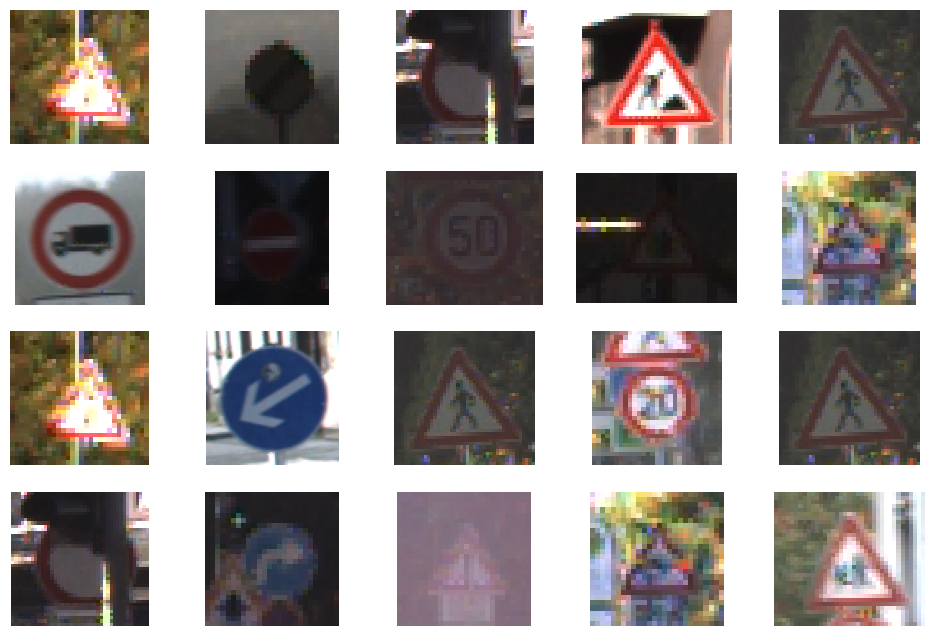

In [6]:

#data Visualation
folder_names = [os.path.join(train_path, str(i)) for i in random.choices(range(43), k=20)] 
file_names = [os.path.join(fldr, os.listdir(fldr)[0]) for fldr in folder_names]

fig, axes = plt.subplots(4, 5, figsize=(12, 8))
for i, image_path in enumerate(file_names):
    image = Image.open(image_path)
    row = i // 5
    col = i % 5
    axes[row, col].imshow(image)
    axes[row, col].axis('off')

plt.show()

In [7]:
# Transforming the Data ToTensor and Normalize it + resize to 28*28

transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Resize((28,28)),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

#creating the dataset class
class GTSR_DataSet(Dataset):
    def __init__(self, df, root_dir,transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        image_path = os.path.join(self.root_dir,self.df.iloc[index,7])  #the column of paths in dataframe is 7
        image = Image.open(image_path)
        y_class = torch.tensor(self.df.iloc[index, 6]) #the column of ClsassId in daraframe is 6
        
        if self.transform:
            image = self.transform(image)
            return (image, y_class)

In [8]:
training_set = GTSR_DataSet(train_df,data_dir,transform=transforms)
test_set = GTSR_DataSet(test_df,data_dir,transform=transforms)

In [9]:
train_loader = DataLoader(dataset = training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_set, batch_size=batch_size, shuffle=False)

dataloaders = {'training':train_loader,'testing':test_loader}
dataset_sizes = {'training':len(train_loader.dataset),'testing':len(test_loader.dataset)}
print(dataset_sizes)

{'training': 39209, 'testing': 12630}


In [10]:
#creating the model
class GTRSB_Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(GTRSB_Model, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)

        # self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        # self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        # self.batchnorm3 = nn.BatchNorm2d(1024)
        # self.maxpool3 = nn.AdaptiveMaxPool2d(512)

        
        self.l1 = nn.Linear(12544,512)
        self.l2 = nn.Linear(512,128)
        self.batchnorm4 = nn.LayerNorm(128)
        self.l3 = nn.Linear(128,output_size)




    def forward(self,input):
        #training pipeline

        conv = self.conv1(input)
        conv = self.conv2(conv)

        batchnorm = self.relu(self.batchnorm1(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv3(maxpool)
        conv = self.conv4(conv)

        batchnorm = self.relu(self.batchnorm2(conv))
        maxpool = self.maxpool(batchnorm)

        # conv = self.conv5(maxpool)
        # conv = self.conv6(conv)
        # batchnorm = self.relu(self.batchnorm3(conv))
        # maxpool = self.maxpool3(batchnorm)
    

              
        flatten = self.flatten(maxpool)
        
        #Neural Network Featuremap input
        dense_l1 = self.l1(flatten)
        dropout = self.dropout3(dense_l1)
        dense_l2 = self.l2(dropout)
        batchnorm = self.batchnorm4(dense_l2)
        dropout = self.dropout2(batchnorm)
        output = self.l3(dropout)
        
    
        return output

In [11]:
input_size = 3*28*28
output_size = 43
model = GTRSB_Model(input_size=input_size, output_size=output_size)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# model deployment
for epoch in range(len(train_loader)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1}, loss = {loss.item()}')

    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for images, labels in test_loader:
            images = images
            labels = labels.to(device)
            outputs = model(images)

            _, predictions = torch.max(outputs, 1)
            n_samples +=labels.shape[0]
            n_correct +=(predictions == labels).sum().item()
        acc = 100.0 * (n_correct / n_samples)
        print(f'accuracy = {acc}')

c:\Users\hosei\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


epoch 1 / 2, step 100, loss = 2.312433958053589
epoch 1 / 2, step 200, loss = 1.409830093383789
epoch 1 / 2, step 300, loss = 0.8074771165847778
epoch 1 / 2, step 400, loss = 0.4040835201740265
epoch 1 / 2, step 500, loss = 0.38785791397094727
epoch 1 / 2, step 600, loss = 0.19729603826999664
epoch 1 / 2, step 700, loss = 0.08056939393281937
epoch 1 / 2, step 800, loss = 0.22102224826812744
epoch 1 / 2, step 900, loss = 0.20694279670715332
epoch 1 / 2, step 1000, loss = 0.48122692108154297
epoch 1 / 2, step 1100, loss = 0.08663667738437653
epoch 1 / 2, step 1200, loss = 0.1419856995344162
accuracy = 91.97149643705464
epoch 2 / 2, step 100, loss = 0.06599327176809311
epoch 2 / 2, step 200, loss = 0.033172957599163055
epoch 2 / 2, step 300, loss = 0.049325671046972275
epoch 2 / 2, step 400, loss = 0.20973503589630127
epoch 2 / 2, step 500, loss = 0.039185781031847
epoch 2 / 2, step 600, loss = 0.01768050715327263
epoch 2 / 2, step 700, loss = 0.10115789622068405
epoch 2 / 2, step 800, lo

KeyboardInterrupt: 